# Training notebook
## Uses Transfer Learning to train a customized 'pretrained_resnet50' model to classify impeller images as either "OK" or "DEFECTIVE"
### To start using this

1. Create the Azure Cascade Lake VM
1. Install docker engine on this VM
1. Clone this repository
    ```
    azureuser@training-instance:~$ pwd
        /home/azureuser
    azureuser@training-instance:~$ git clone https://github.com/scalers-ai/factorysolutions.git
    ```
1. Download the Kaggle dataset mentioned below and extract it into the folder containing this notebook, into a "casting_data" subfolder
1. Navigate to the folder containing this notebook and run the following commands
```
% pip3 install poetry
% poetry install
% jupyter-lab # launch the notebook
```

Then load this notebook in your browser and follow through below steps

In [9]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
import os
os.environ['DISABLE_V2_BEHAVIOR'] = '1'

In [11]:
import os
import sys
import ktrain
from ktrain import vision as vis
import time

### Download impeller dataset from Kaggle [here](https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product)

#### This notebook assumes that the data has been extracted into the "casting_data/" folder

```
ls -l casting_data/
drwxrwxr-x 4 azureuser azureuser 4096 Mar 15 19:08 test
drwxrwxr-x 4 azureuser azureuser 4096 Mar 15 19:08 train
```

In [12]:
DATADIR = 'casting_data/'
(train_data, val_data, preproc) = vis.images_from_folder(
                                              datadir=DATADIR,
                                              data_aug = vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'test'], 
                                              target_size=(224,224), color_mode='rgb')
model = vis.image_classifier('pretrained_resnet50', train_data, val_data, freeze_layers=15)

Found 6633 images belonging to 2 classes.
Found 6633 images belonging to 2 classes.
Found 715 images belonging to 2 classes.
The normalization scheme has been changed for use with a pretrained_resnet50 model. If you decide to use a different model, please reload your dataset with a ktrain.vision.data.images_from* function.

Is Multi-Label? False
Is Regression? False
pretrained_resnet50 model created.


In [13]:
learner = ktrain.get_learner(model=model, train_data=train_data, val_data=val_data, 
                             workers=8, use_multiprocessing=False, batch_size=64)

In [14]:
start = time.time()
learner.fit_onecycle(1e-4, 4)
end = time.time()
elapsed_time=end-start

print(elapsed_time, " seconds to complete training.")



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/4
104/104 [==============================] - ETA: 0s - batch: 51.5000 - size: 63.7788 - loss: 0.5546 - acc: 0.8244

/home/azureuser/.cache/pypoetry/virtualenvs/msbuild-2022-f-n7nuVc-py3.8/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


104/104 [==============================] - 681s 6s/step - batch: 51.5000 - size: 63.7788 - loss: 0.5546 - acc: 0.8244 - val_loss: 1.0804 - val_acc: 0.7189
Epoch 2/4
104/104 [==============================] - 673s 6s/step - batch: 51.5000 - size: 63.7788 - loss: 0.0733 - acc: 0.9786 - val_loss: 0.2125 - val_acc: 0.9455
Epoch 3/4
104/104 [==============================] - 673s 6s/step - batch: 51.5000 - size: 63.7788 - loss: 0.0721 - acc: 0.9845 - val_loss: 0.1499 - val_acc: 0.9580
Epoch 4/4
104/104 [==============================] - 673s 6s/step - batch: 51.5000 - size: 63.7788 - loss: 0.0308 - acc: 0.9911 - val_loss: 0.0317 - val_acc: 0.9874
2702.739191055298  seconds to complete training.


In [15]:
predictor = ktrain.get_predictor(model, preproc)

In [16]:
learner.freeze()

In [17]:
predictor.save("impeller_casting_model")

In [5]:
predictor = ktrain.load_predictor("impeller_casting_model")

/home/ubuntu/.cache/pypoetry/virtualenvs/msbuild-2022-i8QduK1b-py3.8/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [35]:
!!ls {DATADIR}/test/def_front |head -n10

['cast_def_0_1059.jpeg',
 'cast_def_0_1063.jpeg',
 'cast_def_0_108.jpeg',
 'cast_def_0_1096.jpeg',
 'cast_def_0_112.jpeg',
 'cast_def_0_1134.jpeg',
 'cast_def_0_1136.jpeg',
 'cast_def_0_1137.jpeg',
 'cast_def_0_1153.jpeg',
 'cast_def_0_1171.jpeg']

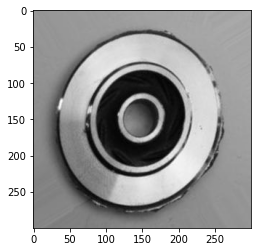

In [36]:
# Test image
vis.show_image(DATADIR+'test/def_front/cast_def_0_1134.jpeg')

In [37]:
predictor.predict_filename(DATADIR+'/test/def_front/cast_def_0_1134.jpeg')

['def_front']

In [27]:
# Show explainable AI heatmap
predictor.explain(DATADIR+'/test/def_front/cast_def_0_1134.jpeg')

### Extract sample images (60 of each class by default, can be changed)

In [29]:
# Run this cell if you want to take a random sampe of 60 images each and run inference on those

import glob, random

def_sample_list = glob.glob(DATADIR+'/test/def_front/' + '*.jpeg')
ok_sample_list = glob.glob(DATADIR+'/test/ok_front/' + '*.jpeg')

def_subset = random.sample(def_sample_list, 60)
ok_subset = random.sample(ok_sample_list, 60)

from PIL import Image
import os

def save_ok_image(ok_img_filename, destination_folder_path):
    img = Image.open(ok_img_filename)
    img.save(destination_folder_path + '/' + os.path.basename(ok_img_filename) + ".png")
    return img

def save_def_image(def_img_filename, destination_folder_path):
    img = predictor.explain(def_img_filename)
    img.save(destination_folder_path + '/' + os.path.basename(def_img_filename) + ".png")
    return img

!mkdir ok_out def_out

for i in def_subset:
    save_def_image(i, "./def_out/")

for i in ok_subset:
    save_ok_image(i, "./ok_out/")


### Freeze Graph and Convert to ONNX

In [ ]:
# Create Frozen Model

!mkdir frozen_model

import tensorflow as tf

tf.saved_model.save(model, "./frozen_model/")

# Create ONNX model and save it into "model.onnx"
!python -m tf2onnx.convert --saved-model frozen_model/ --output model.onnx

/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-04-29 05:40:44,524 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2022-04-29 05:40:48,351 - INFO - Signatures found in model: [serving_default].
2022-04-29 05:40:48,351 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-04-29 05:40:48,352 - INFO - Output names: ['softmax']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-04-29 05:40:49,924 - WARNING - From /home/azureuser/.cache/pypoetry/virtualenvs/msbuild-2022-f-n7nuVc-py3.8/lib/python3.8/site-packages/tf2onnx/tf_loader.py:706: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.

## Convert Model to OpenVINO
### In a shell, launch the OpenVINO Docker Container

```
docker run -it -v /home/azureuser/factorysolutions/training-notebook:/mymodels/ openvino/ubuntu20_data_dev

cd /mymodels/

python3 /opt/intel/openvino_2021.4.752/deployment_tools/model_optimizer/mo.py --saved_model_dir /mymodels/frozen_model/ --input_shape [1,224,224,3]
```

Example Output
```
2022-05-04 02:40:22.207555: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-05-04 02:40:22.207882: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-04 02:40:22.226522: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2793435000 Hz
2022-05-04 02:40:22.256773: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: Graph size after: 1203 nodes (879), 1858 edges (1534), time = 17.586ms.
  function_optimizer: function_optimizer did nothing. time = 0.429ms.

[ SUCCESS ] Generated IR version 10 model.
[ SUCCESS ] XML file: /mymodels/saved_model.xml
[ SUCCESS ] BIN file: /mymodels/saved_model.bin
[ SUCCESS ] Total execution time: 20.80 seconds.
[ SUCCESS ] Memory consumed: 1715 MB.
```

In [2]:
!docker run -it -v /home/azureuser/factorysolutions/training-notebook:/mymodels/ openvino/ubuntu20_data_dev bash -c "cd /mymodels/; python3 /opt/intel/openvino_2021.4.752/deployment_tools/model_optimizer/mo.py --saved_model_dir /mymodels/frozen_model/ --input_shape [1,224,224,3]"

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	None
	- Path for generated IR: 	/mymodels/.
	- IR output name: 	saved_model
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,224,224,3]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared libraries with TensorFlow custom layers implementation: 	None
	- Update the configuration file with input/output node names: 	None
	- Use configuration file used to generate the model with Object Detection API: 	N